dataset  
- amazon review
http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz

- chABSA
https://github.com/chakki-works/chABSA-dataset


https://github.com/ShopRunner/jupyter-notify
```
pip install jupyternotify
```

install mecab and neologd if you use Japanese.

install mecab on mac
```
brew install mecab mecab-ipadic  
pip install mecab-python3
```
install neologd
```
git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
cd mecab-ipadic-neologd
./bin/install-mecab-ipadic-neologd -n
```

In [1]:
import tensorflow as tf
import numpy as np
import re
import os
import time
import datetime
from tensorflow.contrib.learn import preprocessing
import pickle
import pandas as pd
from numpy.random import choice, randint
import MeCab
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
 


%matplotlib inline
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [31]:
class TextCNN:

    def __init__(
        self, sequence_length, num_classes, vocab_size, embedding_size, 
        filter_sizes, num_filters, l2_reg_lambda=0.0):


        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")
        self.loss_weight = tf.placeholder(tf.float32, name="loss_ratio")

        l2_loss = tf.constant(0.0)


        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            self.W = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W")
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

 
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(self.embedded_chars_expanded,W,strides=[1, 1, 1, 1],padding="VALID", name="conv")
                bn_conv = self.batch_normalization(conv) 
                h = tf.nn.relu(tf.nn.bias_add(bn_conv, b), name="relu")
                pooled = tf.nn.max_pool(h, ksize=[1, sequence_length - filter_size + 1, 1, 1],strides=[1, 1, 1, 1],padding='VALID',name="pool")
                pooled_outputs.append(pooled)


        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])
        

        with tf.name_scope("fc-1"):
            W = tf.Variable(tf.truncated_normal([num_filters_total, 1024], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[1024]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            fc_1_output = tf.nn.relu(tf.nn.xw_plus_b(self.h_pool_flat, W, b), name="fc-1-out")


        with tf.name_scope("dropout-1"):
            drop_1 = tf.nn.dropout(fc_1_output, self.dropout_keep_prob)


        with tf.name_scope("fc-2"):
            W = tf.Variable(tf.truncated_normal([1024,1024], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[1024]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            fc_2_output = tf.nn.relu(tf.nn.xw_plus_b(drop_1, W, b), name="fc-2-out")
            
        with tf.name_scope("dropout-2"):
            drop_2 = tf.nn.dropout(fc_2_output, self.dropout_keep_prob)


        with tf.name_scope("fc-3"):
            W = tf.Variable(tf.truncated_normal([1024, num_classes], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(drop_2, W, b, name="output")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")
            
            
        with tf.name_scope("loss"):
      
            #　targets * -log(sigmoid(logits)) * pos_weight +　(1 - targets) * -log(1 - sigmoid(logits))
            losses = tf.nn.weighted_cross_entropy_with_logits(logits=self.scores, targets=self.input_y, pos_weight=self.loss_weight)
            #losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss


        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy") 
            
            
    def batch_normalization(self, x):
        """
          x -> γ(x-μ)/√（σ^2-ε）　+ β
      
          γ : scale
          μ: mean (first moment)
          σ: variance (second moment)
          β: offset
          ε: to avoid dividing by 0
        """
        epsilon = 1e-5
        dim = x.get_shape()[-1]
        scale = tf.Variable(tf.ones([dim]))
        offset = tf.Variable(tf.zeros([dim]))
        mean, variance = tf.nn.moments(x, [0,1,2])
        return tf.nn.batch_normalization(x, mean, variance, offset, scale, epsilon)

In [3]:
#positive_data_file = "data/amazon/book_pos.txt"
#negative_data_file = "data/amazon/book_neg.txt"

long_doc =True

#positive_data_file = "data/chABSA/pos.txt"
#negative_data_file = "data/chABSA/neg.txt"

positive_data_file = "data/amazon_ja/pos.txt"
negative_data_file = "data/amazon_ja/neg.txt"

In [4]:
class Tokenizer:
    def __init__(self):
        mecab = MeCab.Tagger("-Ochasen -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd/")
        self.parser = mecab.parse
            

    def tokenize(self, text):
        text = text.lower()
        l = [line.split("\t") for line in self.parser(text).split("\n")]
        res = " ".join([i[2] for i in l if len(i) >=4]) # has POS.)
        return res

In [5]:
Tokenizer().tokenize("認めたくないものだな。自分自身の若さ故の過ちというものを。")

'認める たい ない もの だ な 。 自分自身 の 若さ故の過ち という もの を 。'

In [6]:
def load_data_and_labels(positive_data_file, negative_data_file, level="char", lang="En"):
       
    positive_examples = list(open(positive_data_file, "r").readlines())
    negative_examples = list(open(negative_data_file, "r").readlines())
    if level == "char":
        positive_examples = [s.replace(" ", "").replace("", " ").lower() for s in positive_examples]
        negative_examples = [s.replace(" ", "").replace("", " ").lower() for s in negative_examples]
    elif level == "word":
        if lang == "Ja":
            t = Tokenizer()
            positive_examples = [t.tokenize(s) for s in positive_examples]
            negative_examples = [t.tokenize(s) for s in negative_examples]
        else:
            positive_examples = [s.strip() for s in positive_examples]
            negative_examples = [s.strip() for s in negative_examples]
    else:
        print("invaid value of 'level'. ('char' or 'word') ")
        
    n_pos = len(positive_examples)
    n_neg = len(negative_examples)
    ratio = n_pos/n_neg
    print("# pos: ", n_pos)
    print("# neg: ", n_neg)
    print("pos/neg:", ratio)
    x_text = positive_examples + negative_examples

    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    
    return x_text, y, ratio

In [7]:
%%notify
#x_text, y, ratio = load_data_and_labels(positive_data_file, negative_data_file, level="word", lang="Ja")
x_text, y, ratio = load_data_and_labels(positive_data_file, negative_data_file, level="char", lang="Ja")

# pos:  30325
# neg:  3876
pos/neg: 7.8237874097007225


<IPython.core.display.Javascript object>

In [8]:
len(x_text)

34201

In [9]:
x_text[0]

' p o c k e t ま で プ レ イ し ま し た 。 こ れ か ら や り 込 み 要 素 を や る と こ ろ で す 。 ス ト ー リ ー に つ い て は 、 今 ま で の 鍵 と は 違 い ま し た 。 し か し 、 そ れ で も と て も 良 か っ た で す 。 昔 、 ど う や っ て 夏 休 み を 過 ご し て い た か 、 考 え ら れ る 作 品 で し た 。 \n '

In [10]:
length_list = np.array([len(r)for r in x_text])

In [11]:
df = pd.DataFrame(length_list, columns=["length"])
df.head()

,length
0,217
1,153
2,997
3,201
4,379


In [12]:
df.describe(percentiles=[0.5,0.75,0.8,0.9,0.95])

,length
count,34201.000000
mean,255.013801
std,343.465457
min,13.000000
50%,177.000000
75%,293.000000
80%,333.000000
90%,467.000000
95%,657.000000
max,17495.000000


In [13]:
#df.quantile(0.95)["length"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c22b489e8>]],
      dtype=object)

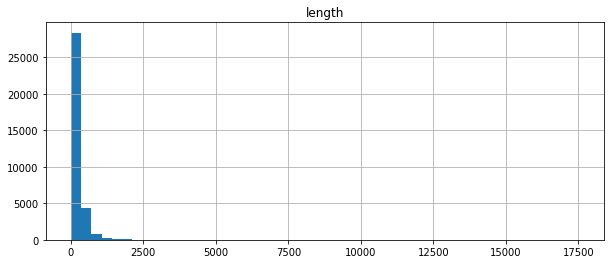

In [14]:
df.hist(bins=50,figsize=(10,4))

In [15]:
max_length = int(df.quantile(0.95)["length"]) #1000
if long_doc:
    x_text = [x[:max_length] if len(x) > max_length else x for x in x_text]
length_list = np.array([len(r)for r in x_text])
df = pd.DataFrame(length_list, columns=["length"])
df.describe(percentiles=[0.5,0.75,0.8,0.9,0.95])

,length
count,34201.000000
mean,227.654542
std,158.706980
min,13.000000
50%,177.000000
75%,293.000000
80%,333.000000
90%,467.000000
95%,657.000000
max,657.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2270e9e8>]],
      dtype=object)

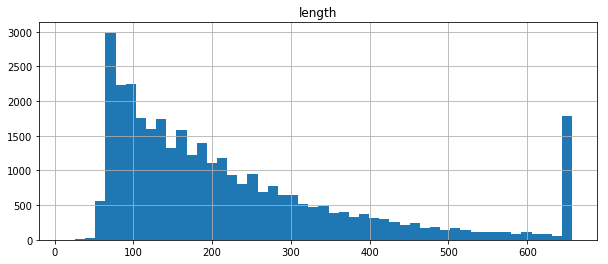

In [16]:
df.hist(bins=50,figsize=(10,4))

In [17]:
vocab_processor = preprocessing.VocabularyProcessor(max_length)

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [18]:
len(x_text)

34201

In [19]:
%%notify
x = np.array(list(vocab_processor.fit_transform(x_text)))

Instructions for updating:
Please use tensorflow/transform or tf.data.


<IPython.core.display.Javascript object>

In [20]:
test_percentage = 0.1 #0.0010 #0.1

In [21]:
%%notify
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

test_sample_index = -1 * int(test_percentage * float(len(y)))
x_train, x_test = x_shuffled[:test_sample_index], x_shuffled[test_sample_index:]
y_train, y_test = y_shuffled[:test_sample_index], y_shuffled[test_sample_index:]

#del x, y, x_shuffled, y_shuffled

print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))

Vocabulary Size: 2911
Train/Test split: 30781/3420


<IPython.core.display.Javascript object>

In [22]:
print(x_train.shape)

(30781, 657)


In [23]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    print("num of epochs: ", num_epochs)
    print("num of batches: ", num_batches_per_epoch)
    print("num of step: ", num_batches_per_epoch*num_epochs)
    for epoch in range(num_epochs):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [24]:
sequence_length = x_train.shape[1]
num_classes = y_train.shape[1]
vocab_size = len(vocab_processor.vocabulary_)

In [25]:
embedding_size = 32     
filter_sizes = [2,3,4,5]    
num_filters=128               
dropout_keep_prob=0.5 
l2_reg_lambda=0.1       

In [28]:
TextCNN(sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda)

In [36]:
batch_size = 64                  
num_epochs = 200            
evaluate_every = 20         
num_checkpoints = 5
learning_rate = 1e-3

allow_soft_placement = True    
log_device_placement = False  

save_checkpoint = True


#timestamp = str(int(time.time()))
#timestamp = "1525609926"
time_path = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
prefix = ""
#out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp, prefix))
out_dir = os.path.join(os.path.curdir, "runs", time_path, prefix)
print("Writing to {}\n".format(out_dir))

Writing to ./runs/2018_07_08_17_36_45/



In [37]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=allow_soft_placement,
      log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    
    with sess.as_default():
        
        cnn = TextCNN(sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda)


        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)


        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)


        loss_summary = tf.summary.scalar("loss", cnn.loss)
        acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        test_summary_op = tf.summary.merge([loss_summary, acc_summary])
        test_summary_dir = os.path.join(out_dir, "summaries", "test")
        test_summary_writer = tf.summary.FileWriter(test_summary_dir, sess.graph)

        if save_checkpoint:
            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

  
        vocab_processor.save(os.path.join(out_dir, "vocab"))


        sess.run(tf.global_variables_initializer())

        def train_step(x_batch, y_batch):
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: dropout_keep_prob,
              cnn.loss_weight: 1.0#ratio
            }
            _, step, summaries, loss, accuracy = sess.run([train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        def test_step(x_batch, y_batch, writer=None):
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: 1.0,
              cnn.loss_weight: 1.0
            }
            step, summaries, loss, accuracy = sess.run([global_step, test_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)

        batches = batch_iter(list(zip(x_train, y_train)), batch_size, num_epochs)
        for batch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            
            if current_step % evaluate_every == 0:
                print("\nEvaluation:")
                test_step(x_test, y_test, writer=test_summary_writer)
                print("")
                
            if save_checkpoint and current_step % evaluate_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))

INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/W:0/grad/hist is illegal; using conv-maxpool-2/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/W:0/grad/sparsity is illegal; using conv-maxpool-2/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/b:0/grad/hist is illegal; using conv-maxpool-2/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/b:0/grad/sparsity is illegal; using conv-maxpool-2/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/Variable:0/grad/hist is illegal; using conv-maxpool-2/Variable_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/Variable:0/grad/sparsity is illegal; using conv-maxpool-2/Variable_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/Vari

2018-07-08T17:37:50.843936: step 40, loss 0.514468, acc 0.879825

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_08_17_36_45/checkpoints/model-40

2018-07-08T17:37:51.665936: step 41, loss 0.521278, acc 0.875
2018-07-08T17:37:52.295573: step 42, loss 0.524113, acc 0.875
2018-07-08T17:37:52.880715: step 43, loss 0.426951, acc 0.921875
2018-07-08T17:37:53.459434: step 44, loss 0.393076, acc 0.9375
2018-07-08T17:37:54.037041: step 45, loss 0.46337, acc 0.890625
2018-07-08T17:37:54.573536: step 46, loss 0.478555, acc 0.875
2018-07-08T17:37:55.109919: step 47, loss 0.442546, acc 0.90625
2018-07-08T17:37:55.746611: step 48, loss 0.461424, acc 0.890625
2018-07-08T17:37:56.292804: step 49, loss 0.353725, acc 0.9375
2018-07-08T17:37:56.917182: step 50, loss 0.442345, acc 0.890625
2018-07-08T17:37:57.444976: step 51, loss 0.458272, acc 0.890625
2018-07-08T17:37:57.964364: step 52, loss 0.549394, acc 0.859375
2018-07-08T17:37:58.538727: step 53, loss 0.419051, acc 0.

2018-07-08T17:39:58.514873: step 151, loss 0.399817, acc 0.859375
2018-07-08T17:39:59.058648: step 152, loss 0.247461, acc 0.9375
2018-07-08T17:39:59.602910: step 153, loss 0.300073, acc 0.921875
2018-07-08T17:40:00.163297: step 154, loss 0.434783, acc 0.859375
2018-07-08T17:40:00.744676: step 155, loss 0.37252, acc 0.875
2018-07-08T17:40:01.319350: step 156, loss 0.192524, acc 0.96875
2018-07-08T17:40:01.926618: step 157, loss 0.428631, acc 0.875
2018-07-08T17:40:02.510830: step 158, loss 0.165979, acc 0.984375
2018-07-08T17:40:03.067872: step 159, loss 0.199689, acc 0.96875
2018-07-08T17:40:03.599838: step 160, loss 0.333278, acc 0.921875

Evaluation:
2018-07-08T17:40:11.306023: step 160, loss 0.42548, acc 0.879825

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_08_17_36_45/checkpoints/model-160

2018-07-08T17:40:12.116428: step 161, loss 0.244384, acc 0.953125
2018-07-08T17:40:12.684536: step 162, loss 0.392277, acc 0.90625
2018-07-08T17:40:13.268304: s

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_08_17_36_45/checkpoints/model-260

2018-07-08T17:42:06.563770: step 261, loss 0.340923, acc 0.890625
2018-07-08T17:42:07.100894: step 262, loss 0.423655, acc 0.828125
2018-07-08T17:42:07.695671: step 263, loss 0.396201, acc 0.84375
2018-07-08T17:42:08.244119: step 264, loss 0.333464, acc 0.890625
2018-07-08T17:42:08.781637: step 265, loss 0.413102, acc 0.859375
2018-07-08T17:42:09.392343: step 266, loss 0.343065, acc 0.890625
2018-07-08T17:42:09.944530: step 267, loss 0.336251, acc 0.90625
2018-07-08T17:42:10.484304: step 268, loss 0.426496, acc 0.84375
2018-07-08T17:42:11.008736: step 269, loss 0.333268, acc 0.90625
2018-07-08T17:42:11.560384: step 270, loss 0.411532, acc 0.859375
2018-07-08T17:42:12.133521: step 271, loss 0.315436, acc 0.90625
2018-07-08T17:42:12.687412: step 272, loss 0.358651, acc 0.890625
2018-07-08T17:42:13.282777: step 273, loss 0.336062, acc 0.90625
2018-07-08T17:42:13.845522: step 274

2018-07-08T17:44:06.071898: step 371, loss 0.404155, acc 0.84375
2018-07-08T17:44:06.827330: step 372, loss 0.278694, acc 0.921875
2018-07-08T17:44:07.667257: step 373, loss 0.262072, acc 0.90625
2018-07-08T17:44:08.428807: step 374, loss 0.340411, acc 0.875
2018-07-08T17:44:09.154219: step 375, loss 0.303158, acc 0.90625
2018-07-08T17:44:09.923766: step 376, loss 0.436949, acc 0.84375
2018-07-08T17:44:10.653715: step 377, loss 0.287008, acc 0.890625
2018-07-08T17:44:11.411058: step 378, loss 0.391366, acc 0.890625
2018-07-08T17:44:12.194152: step 379, loss 0.250745, acc 0.9375
2018-07-08T17:44:12.992721: step 380, loss 0.425526, acc 0.8125

Evaluation:
2018-07-08T17:44:58.584257: step 380, loss 0.325548, acc 0.879825

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_08_17_36_45/checkpoints/model-380

2018-07-08T17:45:00.479913: step 381, loss 0.339708, acc 0.890625
2018-07-08T17:45:01.066062: step 382, loss 0.265127, acc 0.921875
2018-07-08T17:45:01.623125:

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_08_17_36_45/checkpoints/model-480

2018-07-08T17:46:58.267456: step 481, loss 0.221543, acc 0.934426
2018-07-08T17:46:59.050440: step 482, loss 0.348796, acc 0.890625
2018-07-08T17:46:59.625951: step 483, loss 0.313213, acc 0.90625
2018-07-08T17:47:00.297511: step 484, loss 0.266006, acc 0.921875
2018-07-08T17:47:00.837406: step 485, loss 0.216387, acc 0.953125
2018-07-08T17:47:01.382755: step 486, loss 0.288545, acc 0.890625
2018-07-08T17:47:01.946713: step 487, loss 0.209408, acc 0.890625
2018-07-08T17:47:02.621582: step 488, loss 0.238587, acc 0.921875
2018-07-08T17:47:03.270591: step 489, loss 0.278782, acc 0.890625
2018-07-08T17:47:03.860392: step 490, loss 0.305377, acc 0.875
2018-07-08T17:47:04.492750: step 491, loss 0.244343, acc 0.9375
2018-07-08T17:47:05.101535: step 492, loss 0.359266, acc 0.859375
2018-07-08T17:47:05.728478: step 493, loss 0.282258, acc 0.90625
2018-07-08T17:47:06.336240: step 494,

2018-07-08T17:49:05.990914: step 591, loss 0.253618, acc 0.890625
2018-07-08T17:49:06.564269: step 592, loss 0.265584, acc 0.84375
2018-07-08T17:49:07.155435: step 593, loss 0.294887, acc 0.90625
2018-07-08T17:49:07.746531: step 594, loss 0.314758, acc 0.859375
2018-07-08T17:49:08.293993: step 595, loss 0.285988, acc 0.828125
2018-07-08T17:49:08.848180: step 596, loss 0.296946, acc 0.859375
2018-07-08T17:49:09.408575: step 597, loss 0.297118, acc 0.875
2018-07-08T17:49:09.965408: step 598, loss 0.27172, acc 0.890625
2018-07-08T17:49:10.566800: step 599, loss 0.22424, acc 0.921875
2018-07-08T17:49:11.133392: step 600, loss 0.373173, acc 0.859375

Evaluation:
2018-07-08T17:49:19.758856: step 600, loss 0.284829, acc 0.879825

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_08_17_36_45/checkpoints/model-600

2018-07-08T17:49:20.533138: step 601, loss 0.335107, acc 0.875
2018-07-08T17:49:21.101168: step 602, loss 0.197805, acc 0.953125
2018-07-08T17:49:21.729763

2018-07-08T17:51:14.889565: step 701, loss 0.239019, acc 0.90625
2018-07-08T17:51:15.466440: step 702, loss 0.310941, acc 0.875
2018-07-08T17:51:16.129353: step 703, loss 0.558682, acc 0.796875
2018-07-08T17:51:16.722358: step 704, loss 0.294572, acc 0.84375
2018-07-08T17:51:17.315224: step 705, loss 0.363358, acc 0.859375
2018-07-08T17:51:17.880419: step 706, loss 0.359688, acc 0.890625
2018-07-08T17:51:18.422815: step 707, loss 0.30117, acc 0.84375
2018-07-08T17:51:18.979897: step 708, loss 0.191475, acc 0.921875
2018-07-08T17:51:19.550043: step 709, loss 0.239681, acc 0.9375
2018-07-08T17:51:20.094022: step 710, loss 0.258021, acc 0.9375
2018-07-08T17:51:20.654408: step 711, loss 0.263582, acc 0.921875
2018-07-08T17:51:21.201487: step 712, loss 0.50578, acc 0.796875
2018-07-08T17:51:21.765507: step 713, loss 0.404142, acc 0.8125
2018-07-08T17:51:22.342557: step 714, loss 0.284401, acc 0.890625
2018-07-08T17:51:22.932606: step 715, loss 0.238225, acc 0.953125
2018-07-08T17:51:23.5576

2018-07-08T17:54:43.204678: step 813, loss 0.266936, acc 0.890625
2018-07-08T17:54:43.857519: step 814, loss 0.335852, acc 0.84375
2018-07-08T17:54:44.497889: step 815, loss 0.156477, acc 0.984375
2018-07-08T17:54:45.101539: step 816, loss 0.279186, acc 0.890625
2018-07-08T17:54:45.739475: step 817, loss 0.264422, acc 0.859375
2018-07-08T17:54:46.371945: step 818, loss 0.206469, acc 0.890625
2018-07-08T17:54:47.005111: step 819, loss 0.269428, acc 0.875
2018-07-08T17:54:47.669293: step 820, loss 0.214384, acc 0.890625

Evaluation:
2018-07-08T17:55:05.338485: step 820, loss 0.261306, acc 0.879825

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_08_17_36_45/checkpoints/model-820

2018-07-08T17:55:06.463142: step 821, loss 0.215193, acc 0.890625
2018-07-08T17:55:07.222043: step 822, loss 0.191617, acc 0.953125
2018-07-08T17:55:07.914715: step 823, loss 0.192089, acc 0.90625
2018-07-08T17:55:08.607215: step 824, loss 0.282397, acc 0.875
2018-07-08T17:55:09.2672

2018-07-08T17:59:49.137471: step 922, loss 0.186048, acc 0.953125
2018-07-08T17:59:49.832232: step 923, loss 0.291312, acc 0.875
2018-07-08T17:59:50.590848: step 924, loss 0.318784, acc 0.84375
2018-07-08T17:59:51.333099: step 925, loss 0.34567, acc 0.890625
2018-07-08T17:59:52.090419: step 926, loss 0.346865, acc 0.875
2018-07-08T17:59:52.800180: step 927, loss 0.305748, acc 0.890625
2018-07-08T17:59:53.473643: step 928, loss 0.284616, acc 0.859375
2018-07-08T17:59:54.216370: step 929, loss 0.399545, acc 0.78125
2018-07-08T17:59:54.946356: step 930, loss 0.244617, acc 0.9375
2018-07-08T17:59:55.670347: step 931, loss 0.249488, acc 0.890625
2018-07-08T17:59:56.336212: step 932, loss 0.147816, acc 0.953125
2018-07-08T17:59:56.999825: step 933, loss 0.161757, acc 0.9375
2018-07-08T17:59:57.737291: step 934, loss 0.297762, acc 0.890625
2018-07-08T17:59:58.387548: step 935, loss 0.303873, acc 0.90625
2018-07-08T17:59:59.105067: step 936, loss 0.207354, acc 0.890625
2018-07-08T17:59:59.7445

2018-07-08T18:03:08.208339: step 1033, loss 0.157222, acc 0.9375
2018-07-08T18:03:08.893489: step 1034, loss 0.175967, acc 0.9375
2018-07-08T18:03:09.524513: step 1035, loss 0.236207, acc 0.90625
2018-07-08T18:03:10.208122: step 1036, loss 0.110118, acc 0.96875
2018-07-08T18:03:10.899959: step 1037, loss 0.191405, acc 0.921875
2018-07-08T18:03:11.551651: step 1038, loss 0.295502, acc 0.859375
2018-07-08T18:03:12.219107: step 1039, loss 0.276606, acc 0.859375
2018-07-08T18:03:12.876164: step 1040, loss 0.260027, acc 0.921875

Evaluation:
2018-07-08T18:03:30.564983: step 1040, loss 0.242366, acc 0.916959

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_08_17_36_45/checkpoints/model-1040

2018-07-08T18:03:31.705835: step 1041, loss 0.256332, acc 0.890625
2018-07-08T18:03:32.575008: step 1042, loss 0.184119, acc 0.90625
2018-07-08T18:03:33.363862: step 1043, loss 0.323475, acc 0.828125
2018-07-08T18:03:34.211726: step 1044, loss 0.158293, acc 0.90625
2018-07-08

2018-07-08T18:06:32.006129: step 1141, loss 0.365172, acc 0.875
2018-07-08T18:06:32.750224: step 1142, loss 0.274596, acc 0.875
2018-07-08T18:06:33.532460: step 1143, loss 0.361566, acc 0.875
2018-07-08T18:06:34.299270: step 1144, loss 0.16937, acc 0.984375
2018-07-08T18:06:35.037893: step 1145, loss 0.274294, acc 0.859375
2018-07-08T18:06:35.794528: step 1146, loss 0.176092, acc 0.96875
2018-07-08T18:06:36.566523: step 1147, loss 0.230225, acc 0.953125
2018-07-08T18:06:37.295986: step 1148, loss 0.283604, acc 0.890625
2018-07-08T18:06:38.022675: step 1149, loss 0.17492, acc 0.96875
2018-07-08T18:06:38.748303: step 1150, loss 0.250844, acc 0.859375
2018-07-08T18:06:39.484154: step 1151, loss 0.158072, acc 0.9375
2018-07-08T18:06:40.267571: step 1152, loss 0.225274, acc 0.90625
2018-07-08T18:06:41.036656: step 1153, loss 0.284618, acc 0.90625
2018-07-08T18:06:41.769066: step 1154, loss 0.119093, acc 0.953125
2018-07-08T18:06:42.552355: step 1155, loss 0.202686, acc 0.90625
2018-07-08T18

2018-07-08T18:09:34.895142: step 1251, loss 0.174493, acc 0.953125
2018-07-08T18:09:35.563171: step 1252, loss 0.189024, acc 0.953125
2018-07-08T18:09:36.211466: step 1253, loss 0.240119, acc 0.890625
2018-07-08T18:09:36.924787: step 1254, loss 0.218219, acc 0.921875
2018-07-08T18:09:37.664961: step 1255, loss 0.188728, acc 0.9375
2018-07-08T18:09:38.380169: step 1256, loss 0.169946, acc 0.9375
2018-07-08T18:09:39.056830: step 1257, loss 0.144174, acc 0.953125
2018-07-08T18:09:39.749321: step 1258, loss 0.160778, acc 0.921875
2018-07-08T18:09:40.456724: step 1259, loss 0.247965, acc 0.90625
2018-07-08T18:09:41.160753: step 1260, loss 0.252077, acc 0.828125

Evaluation:
2018-07-08T18:09:57.355636: step 1260, loss 0.270094, acc 0.902632

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_08_17_36_45/checkpoints/model-1260

2018-07-08T18:09:58.321281: step 1261, loss 0.184841, acc 0.921875
2018-07-08T18:09:59.021203: step 1262, loss 0.128414, acc 0.984375
2018-07

2018-07-08T18:12:23.452910: step 1360, loss 0.271842, acc 0.900585

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_08_17_36_45/checkpoints/model-1360

2018-07-08T18:12:24.423279: step 1361, loss 0.307798, acc 0.90625
2018-07-08T18:12:25.134412: step 1362, loss 0.234147, acc 0.90625
2018-07-08T18:12:25.842127: step 1363, loss 0.256087, acc 0.9375
2018-07-08T18:12:26.562062: step 1364, loss 0.157483, acc 0.9375
2018-07-08T18:12:27.318962: step 1365, loss 0.400627, acc 0.796875
2018-07-08T18:12:28.039198: step 1366, loss 0.180192, acc 0.9375
2018-07-08T18:12:28.718558: step 1367, loss 0.303959, acc 0.890625
2018-07-08T18:12:29.427588: step 1368, loss 0.27929, acc 0.90625
2018-07-08T18:12:30.068755: step 1369, loss 0.160128, acc 0.984375
2018-07-08T18:12:30.857560: step 1370, loss 0.199684, acc 0.921875
2018-07-08T18:12:31.637376: step 1371, loss 0.181588, acc 0.984375
2018-07-08T18:12:32.366211: step 1372, loss 0.190712, acc 0.90625
2018-07-08T18:12:33.059429

2018-07-08T18:15:20.549018: step 1468, loss 0.207779, acc 0.921875
2018-07-08T18:15:21.231748: step 1469, loss 0.280997, acc 0.90625
2018-07-08T18:15:21.956644: step 1470, loss 0.252974, acc 0.921875
2018-07-08T18:15:22.603517: step 1471, loss 0.193579, acc 0.96875
2018-07-08T18:15:23.321944: step 1472, loss 0.12988, acc 0.984375
2018-07-08T18:15:24.033740: step 1473, loss 0.158522, acc 0.9375
2018-07-08T18:15:24.704041: step 1474, loss 0.237188, acc 0.890625
2018-07-08T18:15:25.413372: step 1475, loss 0.176687, acc 0.953125
2018-07-08T18:15:26.080546: step 1476, loss 0.258216, acc 0.90625
2018-07-08T18:15:26.741712: step 1477, loss 0.167059, acc 0.9375
2018-07-08T18:15:27.442889: step 1478, loss 0.243457, acc 0.9375
2018-07-08T18:15:28.104393: step 1479, loss 0.215049, acc 0.953125
2018-07-08T18:15:28.850359: step 1480, loss 0.193546, acc 0.953125

Evaluation:
2018-07-08T18:15:46.353972: step 1480, loss 0.238911, acc 0.919591

Saved model checkpoint to /Users/tdual/Workspace/char_leve

2018-07-08T18:18:05.535506: step 1578, loss 0.231077, acc 0.90625
2018-07-08T18:18:06.156488: step 1579, loss 0.244314, acc 0.890625
2018-07-08T18:18:06.783090: step 1580, loss 0.138958, acc 0.96875

Evaluation:
2018-07-08T18:18:23.895030: step 1580, loss 0.287053, acc 0.906433

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_08_17_36_45/checkpoints/model-1580

2018-07-08T18:18:24.862102: step 1581, loss 0.390916, acc 0.875
2018-07-08T18:18:25.598663: step 1582, loss 0.205072, acc 0.921875
2018-07-08T18:18:26.310402: step 1583, loss 0.20471, acc 0.90625
2018-07-08T18:18:27.075694: step 1584, loss 0.20631, acc 0.90625
2018-07-08T18:18:27.704886: step 1585, loss 0.277804, acc 0.890625
2018-07-08T18:18:28.350892: step 1586, loss 0.179343, acc 0.9375
2018-07-08T18:18:29.098766: step 1587, loss 0.300305, acc 0.828125
2018-07-08T18:18:29.866193: step 1588, loss 0.146009, acc 0.953125
2018-07-08T18:18:30.584386: step 1589, loss 0.184494, acc 0.953125
2018-07-08T18

2018-07-08T18:20:50.988079: step 1685, loss 0.250097, acc 0.921875
2018-07-08T18:20:51.676842: step 1686, loss 0.253144, acc 0.875
2018-07-08T18:20:52.336100: step 1687, loss 0.183432, acc 0.9375
2018-07-08T18:20:53.080837: step 1688, loss 0.18072, acc 0.984375
2018-07-08T18:20:53.719143: step 1689, loss 0.170527, acc 0.96875
2018-07-08T18:20:54.358774: step 1690, loss 0.106909, acc 0.984375
2018-07-08T18:20:55.023383: step 1691, loss 0.256431, acc 0.953125
2018-07-08T18:20:55.694955: step 1692, loss 0.208089, acc 0.9375
2018-07-08T18:20:56.394483: step 1693, loss 0.33597, acc 0.859375
2018-07-08T18:20:57.026887: step 1694, loss 0.224359, acc 0.90625
2018-07-08T18:20:57.640844: step 1695, loss 0.234885, acc 0.890625
2018-07-08T18:20:58.261584: step 1696, loss 0.207301, acc 0.953125
2018-07-08T18:20:58.956779: step 1697, loss 0.285707, acc 0.921875
2018-07-08T18:20:59.685966: step 1698, loss 0.271904, acc 0.953125
2018-07-08T18:21:00.400884: step 1699, loss 0.206885, acc 0.90625
2018-07

2018-07-08T18:23:15.373897: step 1795, loss 0.255591, acc 0.90625
2018-07-08T18:23:16.050296: step 1796, loss 0.241059, acc 0.953125
2018-07-08T18:23:16.722269: step 1797, loss 0.338995, acc 0.859375
2018-07-08T18:23:17.358773: step 1798, loss 0.157176, acc 0.9375
2018-07-08T18:23:18.060402: step 1799, loss 0.165008, acc 0.9375
2018-07-08T18:23:18.765820: step 1800, loss 0.144234, acc 0.953125

Evaluation:
2018-07-08T18:23:35.764511: step 1800, loss 0.266586, acc 0.920175

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_08_17_36_45/checkpoints/model-1800

2018-07-08T18:23:36.657221: step 1801, loss 0.213225, acc 0.953125
2018-07-08T18:23:37.373765: step 1802, loss 0.339283, acc 0.890625
2018-07-08T18:23:38.078046: step 1803, loss 0.173379, acc 0.96875
2018-07-08T18:23:38.760569: step 1804, loss 0.208765, acc 0.921875
2018-07-08T18:23:39.487361: step 1805, loss 0.201405, acc 0.921875
2018-07-08T18:23:40.187545: step 1806, loss 0.165539, acc 0.984375
2018-07-

2018-07-08T18:26:55.891690: step 1902, loss 0.184531, acc 0.953125
2018-07-08T18:26:56.486231: step 1903, loss 0.2217, acc 0.90625
2018-07-08T18:26:57.058196: step 1904, loss 0.282451, acc 0.921875
2018-07-08T18:26:57.617722: step 1905, loss 0.302693, acc 0.859375
2018-07-08T18:26:58.184418: step 1906, loss 0.188426, acc 0.96875
2018-07-08T18:26:58.798817: step 1907, loss 0.160282, acc 0.9375
2018-07-08T18:26:59.367112: step 1908, loss 0.301012, acc 0.921875
2018-07-08T18:26:59.929001: step 1909, loss 0.406748, acc 0.84375
2018-07-08T18:27:00.488297: step 1910, loss 0.271633, acc 0.890625
2018-07-08T18:27:01.059585: step 1911, loss 0.227633, acc 0.921875
2018-07-08T18:27:01.580468: step 1912, loss 0.224191, acc 0.953125
2018-07-08T18:27:02.152234: step 1913, loss 0.224821, acc 0.921875
2018-07-08T18:27:02.724550: step 1914, loss 0.195495, acc 0.9375
2018-07-08T18:27:03.287291: step 1915, loss 0.157754, acc 0.96875
2018-07-08T18:27:03.837846: step 1916, loss 0.200184, acc 0.96875
2018-0

2018-07-08T18:29:31.704898: step 2012, loss 0.245833, acc 0.9375
2018-07-08T18:29:32.289106: step 2013, loss 0.205243, acc 0.953125
2018-07-08T18:29:32.840507: step 2014, loss 0.151382, acc 0.96875
2018-07-08T18:29:33.402922: step 2015, loss 0.136335, acc 0.96875
2018-07-08T18:29:33.989534: step 2016, loss 0.137124, acc 0.96875
2018-07-08T18:29:34.591414: step 2017, loss 0.226977, acc 0.921875
2018-07-08T18:29:35.190186: step 2018, loss 0.124065, acc 0.984375
2018-07-08T18:29:35.740183: step 2019, loss 0.134951, acc 0.953125
2018-07-08T18:29:36.280958: step 2020, loss 0.198346, acc 0.96875

Evaluation:
2018-07-08T18:29:45.043390: step 2020, loss 0.263113, acc 0.923099

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_08_17_36_45/checkpoints/model-2020

2018-07-08T18:29:45.829068: step 2021, loss 0.136027, acc 0.984375
2018-07-08T18:29:46.505560: step 2022, loss 0.175582, acc 0.96875
2018-07-08T18:29:47.040396: step 2023, loss 0.209233, acc 0.9375
2018-07-08T

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_08_17_36_45/checkpoints/model-2120

2018-07-08T18:32:56.545966: step 2121, loss 0.139443, acc 0.953125
2018-07-08T18:32:57.098309: step 2122, loss 0.224791, acc 0.96875
2018-07-08T18:32:57.711747: step 2123, loss 0.198772, acc 0.9375
2018-07-08T18:32:58.275118: step 2124, loss 0.252515, acc 0.84375
2018-07-08T18:32:58.830849: step 2125, loss 0.205076, acc 0.921875
2018-07-08T18:32:59.502015: step 2126, loss 0.186632, acc 0.9375
2018-07-08T18:33:00.099245: step 2127, loss 0.231833, acc 0.953125
2018-07-08T18:33:00.770075: step 2128, loss 0.12923, acc 0.96875
2018-07-08T18:33:01.329801: step 2129, loss 0.231603, acc 0.953125
2018-07-08T18:33:01.882374: step 2130, loss 0.241764, acc 0.90625
2018-07-08T18:33:02.525170: step 2131, loss 0.295974, acc 0.921875
2018-07-08T18:33:03.211664: step 2132, loss 0.170982, acc 0.984375
2018-07-08T18:33:03.783341: step 2133, loss 0.156532, acc 0.953125
2018-07-08T18:33:04.34771

2018-07-08T18:35:08.289915: step 2229, loss 0.238365, acc 0.890625
2018-07-08T18:35:08.835241: step 2230, loss 0.144311, acc 0.984375
2018-07-08T18:35:09.408681: step 2231, loss 0.389023, acc 0.859375
2018-07-08T18:35:09.974534: step 2232, loss 0.195696, acc 0.953125
2018-07-08T18:35:10.517434: step 2233, loss 0.20966, acc 0.9375
2018-07-08T18:35:11.080784: step 2234, loss 0.213338, acc 0.90625
2018-07-08T18:35:11.655963: step 2235, loss 0.182105, acc 0.9375
2018-07-08T18:35:12.215233: step 2236, loss 0.257833, acc 0.921875
2018-07-08T18:35:12.797398: step 2237, loss 0.154875, acc 0.984375
2018-07-08T18:35:13.371259: step 2238, loss 0.134772, acc 0.953125
2018-07-08T18:35:13.958542: step 2239, loss 0.243121, acc 0.953125
2018-07-08T18:35:14.553733: step 2240, loss 0.133756, acc 0.984375

Evaluation:
2018-07-08T18:35:30.764369: step 2240, loss 0.228651, acc 0.922515

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_08_17_36_45/checkpoints/model-2240

2018-07-

2018-07-08T18:37:09.886827: step 2338, loss 0.182258, acc 0.9375
2018-07-08T18:37:10.453367: step 2339, loss 0.253454, acc 0.921875
2018-07-08T18:37:11.032334: step 2340, loss 0.216245, acc 0.921875

Evaluation:
2018-07-08T18:37:23.418503: step 2340, loss 0.277737, acc 0.922222

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_08_17_36_45/checkpoints/model-2340

2018-07-08T18:37:24.174701: step 2341, loss 0.197835, acc 0.953125
2018-07-08T18:37:24.705984: step 2342, loss 0.325213, acc 0.921875
2018-07-08T18:37:25.260103: step 2343, loss 0.166741, acc 0.9375
2018-07-08T18:37:25.811445: step 2344, loss 0.229449, acc 0.921875
2018-07-08T18:37:26.494972: step 2345, loss 0.247117, acc 0.921875
2018-07-08T18:37:27.043541: step 2346, loss 0.180609, acc 0.9375
2018-07-08T18:37:27.586871: step 2347, loss 0.22247, acc 0.9375
2018-07-08T18:37:28.164266: step 2348, loss 0.183765, acc 0.96875
2018-07-08T18:37:28.732937: step 2349, loss 0.230344, acc 0.9375
2018-07-08T18:

2018-07-08T18:39:23.383205: step 2445, loss 0.165315, acc 0.9375
2018-07-08T18:39:23.965460: step 2446, loss 0.145522, acc 0.96875
2018-07-08T18:39:24.538341: step 2447, loss 0.0946745, acc 0.96875
2018-07-08T18:39:25.176980: step 2448, loss 0.0778151, acc 1
2018-07-08T18:39:25.744686: step 2449, loss 0.284375, acc 0.90625
2018-07-08T18:39:26.291382: step 2450, loss 0.172136, acc 0.953125
2018-07-08T18:39:26.860252: step 2451, loss 0.118711, acc 0.96875
2018-07-08T18:39:27.531359: step 2452, loss 0.149108, acc 0.9375
2018-07-08T18:39:28.116127: step 2453, loss 0.10422, acc 0.984375
2018-07-08T18:39:28.719256: step 2454, loss 0.170979, acc 0.921875
2018-07-08T18:39:29.316401: step 2455, loss 0.136553, acc 0.953125
2018-07-08T18:39:29.938424: step 2456, loss 0.193348, acc 0.953125
2018-07-08T18:39:30.635889: step 2457, loss 0.137525, acc 0.96875
2018-07-08T18:39:31.233234: step 2458, loss 0.116224, acc 0.96875
2018-07-08T18:39:31.784663: step 2459, loss 0.148836, acc 0.953125
2018-07-08T

2018-07-08T18:41:47.679568: step 2555, loss 0.207594, acc 0.953125
2018-07-08T18:41:48.428849: step 2556, loss 0.202904, acc 0.921875
2018-07-08T18:41:49.085011: step 2557, loss 0.239346, acc 0.9375
2018-07-08T18:41:49.676850: step 2558, loss 0.23561, acc 0.90625
2018-07-08T18:41:50.368188: step 2559, loss 0.146175, acc 1
2018-07-08T18:41:51.026662: step 2560, loss 0.157806, acc 0.921875

Evaluation:
2018-07-08T18:42:05.863946: step 2560, loss 0.250693, acc 0.916667

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_08_17_36_45/checkpoints/model-2560

2018-07-08T18:42:06.866847: step 2561, loss 0.158195, acc 0.96875
2018-07-08T18:42:07.570817: step 2562, loss 0.160729, acc 0.90625
2018-07-08T18:42:08.245385: step 2563, loss 0.190026, acc 0.921875
2018-07-08T18:42:08.792302: step 2564, loss 0.134563, acc 0.953125
2018-07-08T18:42:09.427479: step 2565, loss 0.210514, acc 0.90625
2018-07-08T18:42:10.009543: step 2566, loss 0.166836, acc 0.9375
2018-07-08T18:42:1

2018-07-08T18:44:33.287835: step 2662, loss 0.239863, acc 0.953125
2018-07-08T18:44:33.980186: step 2663, loss 0.196054, acc 0.9375
2018-07-08T18:44:34.609187: step 2664, loss 0.122635, acc 0.96875
2018-07-08T18:44:35.172428: step 2665, loss 0.23891, acc 0.890625
2018-07-08T18:44:35.765498: step 2666, loss 0.14058, acc 0.9375
2018-07-08T18:44:36.380570: step 2667, loss 0.127827, acc 0.984375
2018-07-08T18:44:36.976229: step 2668, loss 0.188145, acc 0.953125
2018-07-08T18:44:37.690459: step 2669, loss 0.132514, acc 0.984375
2018-07-08T18:44:38.273547: step 2670, loss 0.20183, acc 0.9375
2018-07-08T18:44:38.863227: step 2671, loss 0.233044, acc 0.9375
2018-07-08T18:44:39.459872: step 2672, loss 0.14936, acc 0.96875
2018-07-08T18:44:40.099667: step 2673, loss 0.18124, acc 0.921875
2018-07-08T18:44:40.688105: step 2674, loss 0.302145, acc 0.890625
2018-07-08T18:44:41.282172: step 2675, loss 0.290864, acc 0.890625
2018-07-08T18:44:42.021057: step 2676, loss 0.126277, acc 0.984375
2018-07-08

2018-07-08T18:46:57.672731: step 2772, loss 0.181141, acc 0.9375
2018-07-08T18:46:58.483423: step 2773, loss 0.179371, acc 0.96875
2018-07-08T18:46:59.104477: step 2774, loss 0.147766, acc 0.984375
2018-07-08T18:46:59.797603: step 2775, loss 0.144741, acc 0.984375
2018-07-08T18:47:00.387471: step 2776, loss 0.16391, acc 0.953125
2018-07-08T18:47:01.000416: step 2777, loss 0.188534, acc 0.9375
2018-07-08T18:47:01.668063: step 2778, loss 0.231198, acc 0.953125
2018-07-08T18:47:02.391173: step 2779, loss 0.106852, acc 0.984375
2018-07-08T18:47:03.104238: step 2780, loss 0.16637, acc 0.9375

Evaluation:
2018-07-08T18:47:20.794697: step 2780, loss 0.227013, acc 0.919591

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_08_17_36_45/checkpoints/model-2780

2018-07-08T18:47:21.864584: step 2781, loss 0.172039, acc 0.96875
2018-07-08T18:47:22.541624: step 2782, loss 0.20116, acc 0.9375
2018-07-08T18:47:23.267580: step 2783, loss 0.189349, acc 0.96875
2018-07-08T18:47

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_08_17_36_45/checkpoints/model-2880

2018-07-08T18:50:09.473369: step 2881, loss 0.179483, acc 0.953125
2018-07-08T18:50:10.115520: step 2882, loss 0.242439, acc 0.890625
2018-07-08T18:50:10.712658: step 2883, loss 0.136127, acc 0.984375
2018-07-08T18:50:11.342947: step 2884, loss 0.161823, acc 0.953125
2018-07-08T18:50:11.948777: step 2885, loss 0.143702, acc 0.9375
2018-07-08T18:50:12.552089: step 2886, loss 0.180949, acc 0.95082
2018-07-08T18:50:13.219520: step 2887, loss 0.161849, acc 0.953125
2018-07-08T18:50:13.779345: step 2888, loss 0.119112, acc 0.984375
2018-07-08T18:50:14.430805: step 2889, loss 0.14084, acc 0.984375
2018-07-08T18:50:15.005270: step 2890, loss 0.0870524, acc 1
2018-07-08T18:50:15.618325: step 2891, loss 0.0998615, acc 0.984375
2018-07-08T18:50:16.198217: step 2892, loss 0.190213, acc 0.953125
2018-07-08T18:50:16.797356: step 2893, loss 0.201887, acc 0.9375
2018-07-08T18:50:17.368179:

2018-07-08T18:52:52.606568: step 2990, loss 0.183768, acc 0.890625
2018-07-08T18:52:53.203982: step 2991, loss 0.106684, acc 0.984375
2018-07-08T18:52:53.839301: step 2992, loss 0.0893835, acc 0.984375
2018-07-08T18:52:54.426783: step 2993, loss 0.122241, acc 0.953125
2018-07-08T18:52:54.992891: step 2994, loss 0.111561, acc 1
2018-07-08T18:52:55.574261: step 2995, loss 0.171904, acc 0.9375
2018-07-08T18:52:56.178804: step 2996, loss 0.124707, acc 0.96875
2018-07-08T18:52:56.769756: step 2997, loss 0.137562, acc 0.984375
2018-07-08T18:52:57.349174: step 2998, loss 0.178477, acc 0.90625
2018-07-08T18:52:57.935619: step 2999, loss 0.170405, acc 0.953125
2018-07-08T18:52:58.538501: step 3000, loss 0.126796, acc 0.96875

Evaluation:
2018-07-08T18:53:15.608546: step 3000, loss 0.244849, acc 0.927778

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_08_17_36_45/checkpoints/model-3000

2018-07-08T18:53:18.543229: step 3001, loss 0.279375, acc 0.890625
2018-07-08T18

2018-07-08T18:56:46.478695: step 3100, loss 0.270565, acc 0.890625

Evaluation:
2018-07-08T18:57:06.569393: step 3100, loss 0.246236, acc 0.92807

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_08_17_36_45/checkpoints/model-3100

2018-07-08T18:57:07.606060: step 3101, loss 0.148406, acc 0.96875
2018-07-08T18:57:08.269362: step 3102, loss 0.137911, acc 0.96875
2018-07-08T18:57:08.853844: step 3103, loss 0.112307, acc 0.984375
2018-07-08T18:57:09.556471: step 3104, loss 0.105788, acc 1
2018-07-08T18:57:10.327430: step 3105, loss 0.162854, acc 0.984375
2018-07-08T18:57:11.076914: step 3106, loss 0.132436, acc 0.96875
2018-07-08T18:57:11.595599: step 3107, loss 0.0697922, acc 1
2018-07-08T18:57:12.244988: step 3108, loss 0.14221, acc 0.96875
2018-07-08T18:57:12.976642: step 3109, loss 0.14768, acc 0.953125
2018-07-08T18:57:13.755064: step 3110, loss 0.206123, acc 0.90625
2018-07-08T18:57:14.420666: step 3111, loss 0.160279, acc 0.953125
2018-07-08T18:57:15.022

2018-07-08T19:00:37.688474: step 3207, loss 0.156464, acc 0.96875
2018-07-08T19:00:38.451792: step 3208, loss 0.164926, acc 0.9375
2018-07-08T19:00:39.211806: step 3209, loss 0.126079, acc 0.953125
2018-07-08T19:00:39.956061: step 3210, loss 0.161234, acc 0.96875
2018-07-08T19:00:40.712737: step 3211, loss 0.119701, acc 0.984375
2018-07-08T19:00:41.455604: step 3212, loss 0.134152, acc 0.953125
2018-07-08T19:00:42.221196: step 3213, loss 0.109014, acc 0.984375
2018-07-08T19:00:43.027399: step 3214, loss 0.146062, acc 0.96875
2018-07-08T19:00:43.791902: step 3215, loss 0.130131, acc 0.984375
2018-07-08T19:00:44.594816: step 3216, loss 0.162404, acc 0.953125
2018-07-08T19:00:45.368763: step 3217, loss 0.0906109, acc 0.984375
2018-07-08T19:00:46.095966: step 3218, loss 0.134683, acc 0.953125
2018-07-08T19:00:46.871800: step 3219, loss 0.135878, acc 0.96875
2018-07-08T19:00:47.598131: step 3220, loss 0.276959, acc 0.90625

Evaluation:
2018-07-08T19:01:46.019205: step 3220, loss 0.261803, a

2018-07-08T19:04:30.829777: step 3317, loss 0.138186, acc 0.953125
2018-07-08T19:04:31.427695: step 3318, loss 0.135652, acc 0.984375
2018-07-08T19:04:32.063941: step 3319, loss 0.182565, acc 0.9375
2018-07-08T19:04:32.742842: step 3320, loss 0.190154, acc 0.9375

Evaluation:
2018-07-08T19:04:51.636946: step 3320, loss 0.244743, acc 0.928655

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_08_17_36_45/checkpoints/model-3320

2018-07-08T19:04:52.676853: step 3321, loss 0.10702, acc 0.96875
2018-07-08T19:04:53.340439: step 3322, loss 0.1332, acc 0.984375
2018-07-08T19:04:53.950695: step 3323, loss 0.134786, acc 0.96875
2018-07-08T19:04:54.584810: step 3324, loss 0.114246, acc 0.984375
2018-07-08T19:04:55.212168: step 3325, loss 0.128316, acc 0.953125
2018-07-08T19:04:55.819476: step 3326, loss 0.141585, acc 0.96875
2018-07-08T19:04:56.435594: step 3327, loss 0.136316, acc 0.984375
2018-07-08T19:04:57.035355: step 3328, loss 0.11409, acc 0.984375
2018-07-08T19

2018-07-08T19:09:15.454826: step 3424, loss 0.0859919, acc 0.984375
2018-07-08T19:09:16.077002: step 3425, loss 0.143407, acc 0.953125
2018-07-08T19:09:16.710854: step 3426, loss 0.115629, acc 0.984375
2018-07-08T19:09:17.304944: step 3427, loss 0.183786, acc 0.953125
2018-07-08T19:09:17.979368: step 3428, loss 0.130445, acc 0.953125
2018-07-08T19:09:18.704728: step 3429, loss 0.16248, acc 0.953125
2018-07-08T19:09:19.452383: step 3430, loss 0.122476, acc 0.96875
2018-07-08T19:09:20.151534: step 3431, loss 0.153827, acc 0.953125
2018-07-08T19:09:20.777003: step 3432, loss 0.155394, acc 0.953125
2018-07-08T19:09:21.381874: step 3433, loss 0.197826, acc 0.953125
2018-07-08T19:09:22.012128: step 3434, loss 0.235733, acc 0.953125
2018-07-08T19:09:22.656773: step 3435, loss 0.183665, acc 0.953125
2018-07-08T19:09:23.263013: step 3436, loss 0.247683, acc 0.9375
2018-07-08T19:09:23.883019: step 3437, loss 0.159694, acc 0.9375
2018-07-08T19:09:24.488569: step 3438, loss 0.103534, acc 0.984375


KeyboardInterrupt: 

##char level cnn 
- 1525408577  
- 1526189751 chABSA  good
- 1523936751 amazon good
- 2018_05_17_12_10_17 chABSA max_length 300
- 2018_07_07_10_13_49 amazon_ja

##word level cnn 
- 2018_05_17_12_46_51chABSA
- 2018_07_07_13_04_25 amazon_ja

In [ ]:
#out_dir = os.path.join(os.path.curdir, "runs", "2018_05_17_12_10_17", prefix)

In [ ]:
ckpt_dir = os.path.join(out_dir, "checkpoints" )
latest_ckpt = tf.train.get_checkpoint_state(ckpt_dir).model_checkpoint_path

In [ ]:
def check_neg_posi(text):
    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
              allow_soft_placement=allow_soft_placement,
              log_device_placement=log_device_placement)
        sess = tf.Session(config=session_conf)
        vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join(out_dir, "vocab"))
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=max_length,
                num_classes=2,
                vocab_size=vocab_size,
                embedding_size=embedding_size,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)
            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())
            saver.restore(sess, latest_ckpt)
        
            text = [s.replace(" ", "").replace("", " ").lower() for s in [text]]
            x = np.array(list(vocab_processor.fit_transform(text)))
            feed_dict = {
                  cnn.input_x: x,
                  cnn.dropout_keep_prob: 1.0
                }
            sess.run(tf.global_variables_initializer())
            feature_2 = sess.run(cnn.scores, feed_dict=feed_dict)
    print(feature_2[0])
    if np.argmax(feature_2[0]):
        print("positive")
    else:
        print("negative")

In [ ]:
check_neg_posi("当四半期連結累計期間の営業利益は、前年同期比5,184億円増加し、7,127億円となりました。この大幅な増益は、主に半導体分野の大幅な損益改善及び前年同期に映画分野の営業権の減損損失を計上していたことによるものです。 ")

In [ ]:
check_neg_posi("伸び率は減少傾向にありました。")

In [ ]:
check_neg_posi("伸び率は加向にありました。")

In [ ]:
check_neg_posi("伸び率は減向にありました。")

In [ ]:
def eval_acc(x, y, max_length):
    with tf.Graph().as_default():
        with tf.Session() as sess:
            cnn = TextCNN(
                sequence_length=max_length,
                num_classes=2,
                vocab_size=vocab_size,
                embedding_size=embedding_size,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)
            
            sess.run(tf.global_variables_initializer())
            saver = tf.train.Saver()
            
            saver.restore(sess, latest_ckpt)
        
            feed_dict = {
              cnn.input_x: x,
              cnn.input_y: y,
              cnn.dropout_keep_prob: 1.0
            }
            acc, scores = sess.run([cnn.accuracy, cnn.scores], feed_dict=feed_dict)
    return acc, scores

In [ ]:
max_length

In [ ]:
def drop_char(x_test ,n):
    drop_x_test = []
    for x in  x_test:
        x_c = x.copy()
        for i in choice(range(max_length), n,replace=False):
            x_c[i] = randint(max_length)
        drop_x_test.append(x_c)
    return drop_x_test

In [ ]:
a,s = eval_acc(x_test, y_test, max_length=max_length)
a

In [ ]:
a,s = eval_acc(drop_char(x_test, 100), y_test, max_length=max_length)
a

In [ ]:
r = []
for i in tqdm(range(max_length)):
    a,s = eval_acc(drop_char(x_test, i), y_test, max_length=max_length)
    print(a)
    r.append(a)

In [ ]:
plt.plot(range(max_length), r)
plt.show()

word level

In [ ]:
def create_drop_doc(positive_data_file, negative_data_file, n):
       
    positive_examples = list(open(positive_data_file, "r").readlines())
    negative_examples = list(open(negative_data_file, "r").readlines())
    po = []
    ne = []
    t = Tokenizer()
    for e in positive_examples:
        if len(e) < n:
            e_ = ""
            for _ in  range(len(e)):
                e_ += chr(randint(12354, 20000)) + " "
            e = e_
        else:
            max_n = n
            for i in choice(range(len(e)), max_n, replace=False):
                e = e.replace(e[i], chr(randint(12354, 20000)))
        po.append(t.tokenize(e))
        
    for e in negative_examples:
        if len(e) < n:
            e = "{} ".format(chr(randint(12354, 20000))) * len(e)
        else:
            max_n = n
            for i in choice(range(len(e)), max_n, replace=False):
                e = e.replace(e[i], chr(randint(12354, 20000)))
        ne.append(t.tokenize(e))

   
    positive_examples = po
    negative_examples = ne
        
    x_text = positive_examples + negative_examples

    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    
    #return po, y
    return x_text, y

In [ ]:
x_, y_ = create_drop_doc(positive_data_file, negative_data_file, 300)

In [ ]:
x_[1]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x_)))

In [ ]:
x = x[shuffle_indices][test_sample_index:]

In [ ]:
a,s = eval_acc(x_test, y_test, max_length=max_length)
a

In [ ]:
a,s = eval_acc(x, y_test, max_length=max_length)
a

In [ ]:
r = []
for i in tqdm(range(max_length)):
    x_, y_ = create_drop_doc(positive_data_file, negative_data_file, i)
    x = np.array(list(vocab_processor.fit_transform(x_)))
    x = x[shuffle_indices][test_sample_index:]
    a,s = eval_acc(x, y_test,max_length=max_length)
    print(a)
    r.append(a)

In [ ]:
plt.plot(range(max_length), r)
plt.show()

In [ ]:
a,s = eval_acc(drop_char(), y_test, max_length=max_length)
a

In [ ]:
#out_dir="runs/1523936751"

In [ ]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
          allow_soft_placement=allow_soft_placement,
          log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join(out_dir, "vocab"))
    with sess.as_default():
        cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_size,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)
        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, latest_ckpt)
        #sess.run(tf.global_variables_initializer())
        w = sess.run(cnn.W, feed_dict={cnn.input_x: x_test})

In [ ]:
w

In [ ]:
w.shape

In [ ]:
with open('embedding_tensor.tsv','w') as f:
    for char_vec in w:
        for weight in char_vec:
            f.write(str(weight)+ "\t")
        f.write("\n")

In [ ]:
#vocab_dict = vocab_processor.vocabulary_._mapping
vocab_dict = vocab_processor.vocabulary_._reverse_mapping

In [ ]:
vocab_dict[1]

In [ ]:
with  open('embedding_metadata.tsv' ,'w') as f:
    f.write('Titles\tGenres\n')
    for i,v in enumerate(w):
        f.write("%s\t%s\n" % (vocab_dict[i], vocab_dict[i]))

In [ ]:
def get_feature(x):
    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
          allow_soft_placement=allow_soft_placement,
          log_device_placement=log_device_placement)
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_dim,
                filter_sizes=list(map(int, filter_sizes.split(","))),
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)

            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())

            saver.restore(sess, latest_ckpt)

            feed_dict = {
                  cnn.input_x: x,
                  cnn.dropout_keep_prob: 1.0
                }
            feature_5, feature_2 = sess.run([cnn.f_h, cnn.scores ], feed_dict=feed_dict)
    return feature_5, feature_2


In [ ]:
review = list(open("data/amazon/rating_5.txt", "r").readlines())
review = [s.strip() for s in review]

In [ ]:
y = []
x = []
for r in review:
    l = r.split(":::::")
    y.append(float(l[0]))
    x.append(l[1].replace(" ", "").replace("", " "))

In [ ]:
vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join("runs/1525408577", "vocab"))

In [ ]:
x[0]

In [ ]:
y[0]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x)))
y = np.array(y)

In [ ]:
len(x)

In [ ]:
feature_5 ,feature_2 = get_feature(x[:100])

In [ ]:
feature_5[0]

In [ ]:
feature_5[1]

In [ ]:
s = 0
chunk_size = 100
for i in range(0, len(x) , chunk_size):
    feature_5 ,feature_2 = get_feature(x[i:i+chunk_size])
    for f, r in zip(feature_5, y[i:i+chunk_size]):
        s  += int(np.argmax(f) == r)
    print(s/(i+chunk_size))
s

In [ ]:
np.argmax(feature_5)

In [ ]:
feature_2 [0]  #[neg, pos]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x_text)))